In [17]:

import pip
pip.main(['install','seaborn'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Defaulting to user installation because normal site-packages is not writeable


0

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
news_scores = { 
    "dutch" : {
        'Telegraaf' : 3.6,
        'Geenstijl' : 3.6,
        'RTL' : 3.4,
        'NOS' : 3.3,
        'NU.nl' : 3.3,
        'AD' : 3.4,
        'Volkskrant' : 2.9
    },

    "german" : {
        'Bild' : 3.1,
        'FAZ' : 2.9,
        'RTL' : 3.0,
        'Sat1' : 3.0,
        'Sz' : 2.8,
        'ARD' : 2.9,
        'Der Spiegel' : 2.8
    },   
    "french" : {
        'TF1' : 3.3,
        'Le Figaro' : 3.3,
        'BFM' : 3.2,
        "L'Express" : 2.9,
        'Le Monde' : 2.9,
        'France 2' : 3.1,
        'Libération' : 2.5,
        'Mediapart' : 2.4
    }
}


In [20]:
news_scores = {'dutch': {
    'Telegraaf': 1.0,
    'Geenstijl': 1.0,
    'RTL': 0.6666666666666665,
    'NOS': 0.49999999999999956,
    'NU.nl': 0.49999999999999956,
    'AD': 0.6666666666666665,
    'Volkskrant': -0.16666666666666674,
    }, 'german': {
    'Bild': 0.16666666666666674,
    'FAZ': -0.16666666666666674,
    'RTL': 0.0,
    'Sat1': 0.0,
    'Sz': -0.3333333333333336,
    'ARD': -0.16666666666666674,
    'Der Spiegel': -0.3333333333333336,
    }, 'french': {
    'TF1': 0.49999999999999956,
    'Le Figaro': 0.49999999999999956,
    'BFM': 0.3333333333333335,
    "L'Express": -0.16666666666666674,
    'Le Monde': -0.16666666666666674,
    'France 2': 0.16666666666666674,
    'Libération': -0.8333333333333333,
    'Mediapart': -1.0,
    }}


In [21]:
# mean_dutch = sum(news_scores['dutch'].values()) / len(news_scores['dutch'])
# mean_german = sum(news_scores['german'].values()) / len(news_scores['german'])
# print(f"Mean for Dutch: {mean_dutch:.3f}")
# print(f"Mean for German: {mean_german:.3f}")

In [22]:
# normalizer

all_scores = []
for language in news_scores.values():
    all_scores.extend(language.values())
# Step 2: Calculate the overall min and max values
min_score = min(all_scores)
max_score = max(all_scores)
# Step 3: Normalize the scores to the range [-1, 1]
normalized_scores = {}
for language, sites in news_scores.items():
    normalized_scores[language] = {
        site: (2 * (score - min_score) / (max_score - min_score)) - 1
        for site, score in sites.items()
    }
# Print the normalized scores
print(normalized_scores)

{'dutch': {'Telegraaf': 1.0, 'Geenstijl': 1.0, 'RTL': 0.6666666666666665, 'NOS': 0.49999999999999956, 'NU.nl': 0.49999999999999956, 'AD': 0.6666666666666665, 'Volkskrant': -0.16666666666666674}, 'german': {'Bild': 0.16666666666666674, 'FAZ': -0.16666666666666674, 'RTL': 0.0, 'Sat1': 0.0, 'Sz': -0.3333333333333336, 'ARD': -0.16666666666666674, 'Der Spiegel': -0.3333333333333336}, 'french': {'TF1': 0.49999999999999956, 'Le Figaro': 0.49999999999999956, 'BFM': 0.3333333333333335, "L'Express": -0.16666666666666674, 'Le Monde': -0.16666666666666674, 'France 2': 0.16666666666666674, 'Libération': -0.8333333333333333, 'Mediapart': -1.0}}


In [23]:
scores_per_place = {
                    1: 0.28,
                    2: 0.25,
                    3: 0.22,
                    4: 0.15,
                    5: 0.10
                    }

In [24]:
def process_score(row, start, xend, language):
    scores = news_scores[language]
    score = 0
    nr_of_found = 0
    for site in row.index[start+1:xend+1]:
        # print(site)
        site_stripped = site[:-2] 
        site_place = row[site]
        if site_place != 0:
            if isinstance(site_place, str):
                    if ',' in site_place:
                        splitted = site_place.split(',')
                        for spl in splitted:
                            score += scores[site_stripped]
                            nr_of_found+=1
                            
                    else:
                        site_place = int(site_place)
                        score += scores[site_stripped]
                        nr_of_found+=1
            else:
                score += scores[site_stripped]
                nr_of_found+=1
    if score != 0:
        score = score/nr_of_found
    else:
        score = 0
    return score

In [25]:
def compute_scores(df, lang):
    # compute score per query
    df['score-c'] = df.apply(
            lambda row: process_score(row, 0, 7, lang), axis=1
        )
    df['score-d'] = df.apply(
            lambda row: process_score(row, 7, 14, lang), axis=1
        )
    df['score-g'] = df.apply(
            lambda row: process_score(row, 14, 21, lang), axis=1
        )

    # compute avg
    # Replace 0 with NaN for specific columns
    cols_to_average = ['score-c', 'score-d', 'score-g']
    df[cols_to_average] = df[cols_to_average].replace(0, pd.NA)
    df['score-avg'] = df[cols_to_average].mean(axis=1)
    return df

In [26]:
def calculate_stats(data):
    data = np.sort(data)
    
    # Basic boxplot statistics
    min_val = round(np.min(data), 2)
    max_val = round(np.max(data), 2)
    q1 = round(np.percentile(data, 25), 2)
    median = round(np.median(data), 2)
    q3 = round(np.percentile(data, 75), 2)
    mean = round(np.mean(data), 2)
    
    # Interquartile range (IQR)
    iqr = round(q3 - q1, 2)
    
    # Whiskers
    lower_whisker = round(max(min_val, q1 - 1.5 * iqr), 2)
    upper_whisker = round(min(max_val, q3 + 1.5 * iqr), 2)
    
    # Outliers
    lower_outliers = [x for x in data if x < q1 - 1.5 * iqr]
    upper_outliers = [x for x in data if x > q3 + 1.5 * iqr]
    
    # Variance
    variance = round(np.var(data, ddof=0), 2)  # Use ddof=0 for population variance

    # Organize results into a dictionary
    stats = {
        'min': min_val,
        'max': max_val,
        '25th_percentile (Q1)': q1,
        'median (Q2)': median,
        '75th_percentile (Q3)': q3,
        'mean': mean,
        'IQR': iqr,
        'lower_whisker': lower_whisker,
        'upper_whisker': upper_whisker,
        'lower_outliers': lower_outliers,
        'upper_outliers': upper_outliers,
        'variance': variance
    }
    
    return stats

def plot_avg(df, title):

    plt.figure(figsize=(8, 2))
    # plt.scatter(df['score-avg'], [0] * len(df), color='b', alpha=0.7)
    sns.boxplot(x=df['score-avg'], color='#8ecae6', zorder=1)
    plt.scatter(df['score-avg'], [0] * len(df), color='#023e8a', alpha=0.9, s=50, zorder=2)

    # offset = 0.007  # Offset value to prevent overlap
    # for i, value in enumerate(df['score-avg']):
    #     # Adjust the y position slightly for each label to avoid overlap
    #     plt.text(value, (-offset * (i + 1)) -0.04, str(df['Participant'].iloc[i]), 
    #             horizontalalignment='center', verticalalignment='top', 
    #             color='black', size=8)
    
    plt.xlim(-1, 1)
    plt.xlabel('Score Average')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()
    
    stats = calculate_stats(df['score-avg'])
    for key, value in stats.items():
        print(key, value)


In [27]:
file_path_dutch = "IR_data_Dutch.csv"
file_path_german = "IR_data_German.csv"
file_path_french = "IR_data_French.csv"

dutch_df = pd.read_csv(file_path_dutch)
dutch_df = dutch_df.fillna(0)

german_df = pd.read_csv(file_path_german)
german_df = german_df.fillna(0)

french_df = pd.read_csv(file_path_french)
french_df = french_df.fillna(0)

# print(dutch_df)

dutch_df_extended = compute_scores(dutch_df, 'dutch')
german_df_extended = compute_scores(german_df, 'german')
french_df_extended = compute_scores(french_df, 'french')

In [28]:
df_together = pd.concat([dutch_df_extended, german_df_extended], ignore_index=True)
df_together = pd.concat([df_together, french_df_extended], ignore_index=True)
df_m = df_together[df_together['Gender'] == 'm']  # Male DataFrame
df_f = df_together[df_together['Gender'] == 'f']  # Female DataFrame
print(len(df_m))
print(len(df_f))


14
14


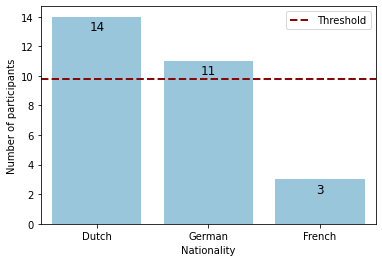

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Import for custom legend line


# Assuming 'df' is your pandas DataFrame
# sns.set_palette("Blues")  # You can use other palettes like "Set1", "viridis", etc.

# Create the count plot
ax = sns.countplot(x='Nationality', data=df_together, color='#8ecae6')

# Add labels and title for better readability
plt.xlabel('Nationality')
plt.ylabel('Number of participants')
# plt.title('Count of Each Nationality')

# Annotate each bar with the actual count
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, -10), textcoords='offset points')

threshold_line = ax.axhline(y=9.8, color='#880808', linestyle='--', linewidth=2)


# Create a custom legend entry for the threshold line
custom_legend = [Line2D([0], [0], color='#880808', linestyle='--', linewidth=2, label='Threshold')]

# Add the custom legend to the plot
ax.legend(handles=custom_legend)

# Show the plot
plt.show()

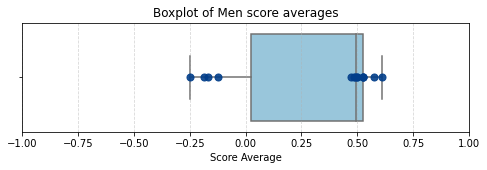

min -0.25
max 0.61
25th_percentile (Q1) 0.02
median (Q2) 0.5
75th_percentile (Q3) 0.53
mean 0.32
IQR 0.51
lower_whisker -0.25
upper_whisker 0.61
lower_outliers []
upper_outliers []
variance 0.1


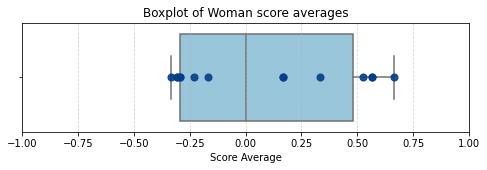

min -0.33
max 0.67
25th_percentile (Q1) -0.3
median (Q2) -0.0
75th_percentile (Q3) 0.48
mean 0.08
IQR 0.78
lower_whisker -0.33
upper_whisker 0.67
lower_outliers []
upper_outliers []
variance 0.14


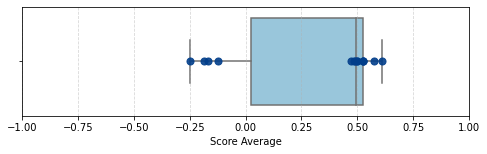

min -0.25
max 0.61
25th_percentile (Q1) 0.02
median (Q2) 0.5
75th_percentile (Q3) 0.53
mean 0.32
IQR 0.51
lower_whisker -0.25
upper_whisker 0.61
lower_outliers []
upper_outliers []
variance 0.1


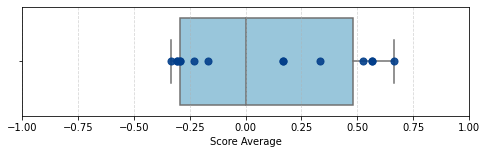

min -0.33
max 0.67
25th_percentile (Q1) -0.3
median (Q2) -0.0
75th_percentile (Q3) 0.48
mean 0.08
IQR 0.78
lower_whisker -0.33
upper_whisker 0.67
lower_outliers []
upper_outliers []
variance 0.14


In [30]:
plot_avg(df_m, "Boxplot of Men score averages")
plot_avg(df_f, "Boxplot of Woman score averages")
plot_avg(df_m, "")
plot_avg(df_f, "")

In [49]:
import numpy as np
from scipy import stats

def test(a, b):
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(dutch_list, german_list)
    # Output results
    print("PAIRED T-TEST")
    print("t-statistic:", t_stat)
    print("p-value:", p_value)
    # Interpretation of p-value
    if p_value < 0.05:
        print("There is a significant difference between the two lists.")
    else:
        print("There is no significant difference between the two lists.")
        
    # Perform Levene’s test for equality of variances
    stat, p_value = stats.levene(dutch_list, german_list)
    # Output results
    print("LEVENE'S TEST (VARIANCE)")

    print("Levene’s test statistic:", stat)
    print("p-value:", p_value)

    # Interpretation of p-value
    if p_value < 0.05:
        print("There is a significant difference between the variances.")
    else:
        print("There is no significant difference between the variances.")
    


In [51]:
dutch_list = dutch_df_extended['score-avg'].tolist()
dutch_list = dutch_list[:11]
german_list = german_df_extended['score-avg'].tolist()

# NEDERLANDS DUITS
test(dutch_list, german_list)


PAIRED T-TEST
t-statistic: 25.550583648335092
p-value: 1.9356653996678214e-10
There is a significant difference between the two lists.
LEVENE'S TEST (VARIANCE)
Levene’s test statistic: 0.44536101584947746
p-value: 0.512173480300502
There is no significant difference between the variances.


In [52]:
# MAN VROUW
test(df_m, df_f)


PAIRED T-TEST
t-statistic: 25.550583648335092
p-value: 1.9356653996678214e-10
There is a significant difference between the two lists.
LEVENE'S TEST (VARIANCE)
Levene’s test statistic: 0.44536101584947746
p-value: 0.512173480300502
There is no significant difference between the variances.


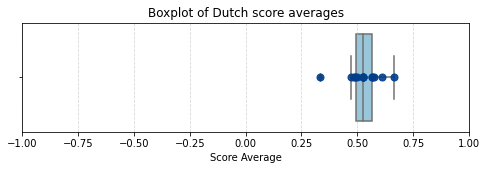

min 0.33
max 0.67
25th_percentile (Q1) 0.49
median (Q2) 0.53
75th_percentile (Q3) 0.56
mean 0.53
IQR 0.07
lower_whisker 0.38
upper_whisker 0.66
lower_outliers [0.3333333333333331]
upper_outliers [0.6666666666666665]
variance 0.01


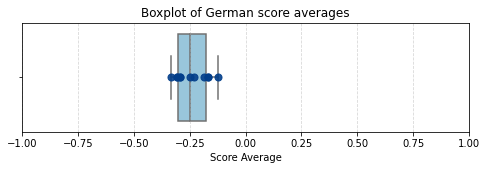

min -0.33
max -0.13
25th_percentile (Q1) -0.3
median (Q2) -0.25
75th_percentile (Q3) -0.18
mean -0.24
IQR 0.12
lower_whisker -0.33
upper_whisker -0.13
lower_outliers []
upper_outliers []
variance 0.0


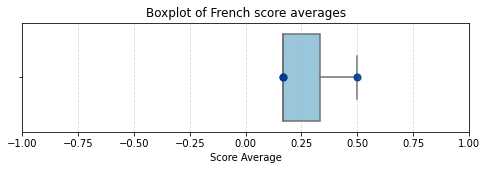

min 0.17
max 0.5
25th_percentile (Q1) 0.17
median (Q2) 0.17
75th_percentile (Q3) 0.33
mean 0.28
IQR 0.16
lower_whisker 0.17
upper_whisker 0.5
lower_outliers []
upper_outliers []
variance 0.02


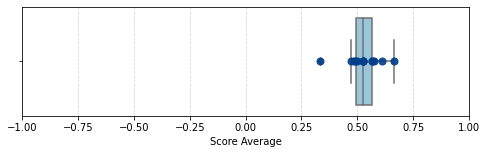

min 0.33
max 0.67
25th_percentile (Q1) 0.49
median (Q2) 0.53
75th_percentile (Q3) 0.56
mean 0.53
IQR 0.07
lower_whisker 0.38
upper_whisker 0.66
lower_outliers [0.3333333333333331]
upper_outliers [0.6666666666666665]
variance 0.01


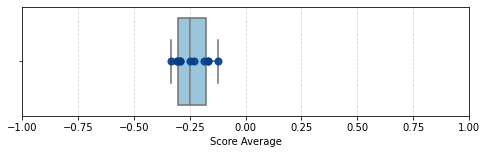

min -0.33
max -0.13
25th_percentile (Q1) -0.3
median (Q2) -0.25
75th_percentile (Q3) -0.18
mean -0.24
IQR 0.12
lower_whisker -0.33
upper_whisker -0.13
lower_outliers []
upper_outliers []
variance 0.0


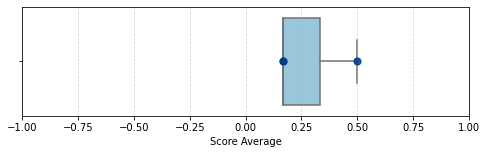

min 0.17
max 0.5
25th_percentile (Q1) 0.17
median (Q2) 0.17
75th_percentile (Q3) 0.33
mean 0.28
IQR 0.16
lower_whisker 0.17
upper_whisker 0.5
lower_outliers []
upper_outliers []
variance 0.02


In [31]:
plot_avg(dutch_df_extended, "Boxplot of Dutch score averages")
plot_avg(german_df_extended, "Boxplot of German score averages")
plot_avg(french_df_extended, "Boxplot of French score averages")
plot_avg(dutch_df_extended, "")
plot_avg(german_df_extended, "")
plot_avg(french_df_extended, "")

In [32]:

def top_sites(c, d, g):

    top3_scores = (
        pd.DataFrame({'C': c, 'D': d, 'G': g})
        .reset_index()
        .rename(columns={'index': 'Website'})
        .assign(Website=lambda x: x['Website'].str[:-2])
        .groupby('Website', as_index=False)
        .sum()
    )

    top3_c = top3_scores.nlargest(3, 'C')[['Website', 'C']].rename(columns={'C': 'Count'})
    top3_d = top3_scores.nlargest(3, 'D')[['Website', 'D']].rename(columns={'D': 'Count'})
    top3_g = top3_scores.nlargest(3, 'G')[['Website', 'G']].rename(columns={'G': 'Count'})

    # Display top 3 for each column
    print("Top 3 for Corona:\n", top3_c)
    print("\nTop 3 for Donald Trump:\n", top3_d)
    print("\nTop 3 for Gaza:\n", top3_g)
    return top3_c, top3_d, top3_g

c = (dutch_df_extended.iloc[:, 1:8] != 0).sum(axis=0)
d = (dutch_df_extended.iloc[:, 8:15] != 0).sum(axis=0)
g = (dutch_df_extended.iloc[:, 15:22] != 0).sum(axis=0)
top3_c, top3_d, top3_g = top_sites(c, d, g)
c = (german_df_extended.iloc[:, 1:8] != 0).sum(axis=0)
d = (german_df_extended.iloc[:, 8:15] != 0).sum(axis=0)
g = (german_df_extended.iloc[:, 15:22] != 0).sum(axis=0)
top3_c_g, top3_d_g, top3_g_g = top_sites(c, d, g)

top_sites(c, d, g)


Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Top 3 for Corona:
       Website  Count
6  Volkskrant   13.0
0          AD   12.0
2         NOS    3.0

Top 3 for Donald Trump:
      Website  Count
5  Telegraaf   12.0
0         AD   10.0
2        NOS    4.0

Top 3 for Gaza:
      Website  Count
3      NU.nl   11.0
0         AD    5.0
5  Telegraaf    5.0
Top 3 for Corona:
        Website  Count
2  Der Spiegel    7.0
0          ARD    6.0
6           Sz    4.0

Top 3 for Donald Trump:
        Website  Count
2  Der Spiegel    6.0
3          FAZ    2.0
1         Bild    1.0

Top 3 for Gaza:
        Website  Count
2  Der Spiegel    8.0
3          FAZ    6.0
6           Sz    1.0
Top 3 for Corona:
        Website  Count
2  Der Spiegel    7.0
0          ARD    6.0
6           Sz    4.0

Top 3 for Donald Trump:
        Website  Count
2  Der Spiegel    6.0
3          FAZ    2.0
1         Bild    1.0

Top 3 for Gaza

(       Website  Count
 2  Der Spiegel    7.0
 0          ARD    6.0
 6           Sz    4.0,
        Website  Count
 2  Der Spiegel    6.0
 3          FAZ    2.0
 1         Bild    1.0,
        Website  Count
 2  Der Spiegel    8.0
 3          FAZ    6.0
 6           Sz    1.0)

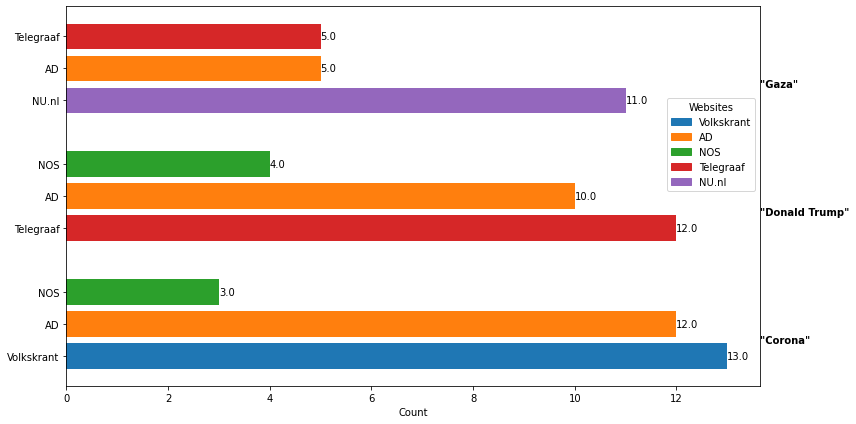

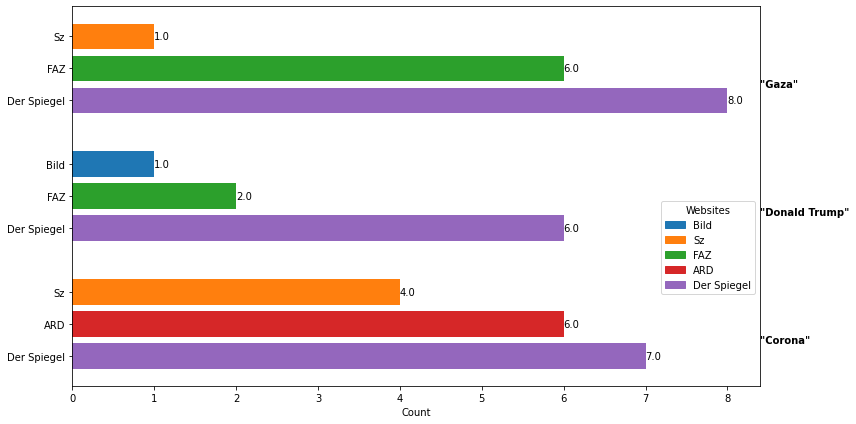

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import colorsys

def generate_distinct_colors(n):
    """
    Generate a list of visually distinct colors for n websites.
    
    Args:
    n (int): Number of distinct colors to generate
    
    Returns:
    list: List of color hex codes
    """
    # Start with a base set of distinct colors
    base_colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
    ]
    
    # If we need more colors than base colors, generate additional ones
    if n > len(base_colors):
        # Generate additional colors using HSV color space
        hue_step = 1.0 / (n - len(base_colors) + 1)
        for i in range(len(base_colors), n):
            hue = (i * hue_step) % 1.0
            # Use distinct saturation and value to create variety
            sat = 0.7 + 0.3 * ((i % 3) / 2)
            val = 0.7 + 0.3 * ((i % 2))
            rgb = colorsys.hsv_to_rgb(hue, sat, val)
            base_colors.append(mcolors.to_hex(rgb))
    
    return base_colors[:n]

def create_grouped_bar_plot(dataframes, group_names, lang, legend_loc):
    """
    Create a grouped horizontal bar plot with dynamically generated colors.
    
    Args:
    dataframes (list): List of DataFrames, each representing a group
    group_names (list): List of group names
    
    Returns:
    matplotlib figure
    """
    # Collect all unique websites
    all_websites = list(set([website for df in dataframes for website in df['Website']]))
    
    # Generate color map for websites
    color_map = dict(zip(all_websites, generate_distinct_colors(len(all_websites))))
    
    # Prepare data and colors
    y_positions = []
    counts = []
    colors = []
    y_labels = []
    current_y = 0
    
    for i, (df, group) in enumerate(zip(dataframes, group_names)):
        group_websites = df['Website'].tolist()
        group_counts = df['Count'].tolist()
        
        # Add group's websites and counts
        y_positions.extend(range(current_y, current_y + len(group_websites)))
        counts.extend(group_counts)
        colors.extend([color_map[website] for website in group_websites])
        y_labels.extend(group_websites)
        
        # Add group label text position
        current_y += len(group_websites) + 1
    
    # Create the figure and axis
    plt.figure(figsize=(12, 6))
    
    # Create the horizontal bar plot
    bars = plt.barh(y_positions, counts, height=0.8, color=colors)
    
    # Customize the plot
    plt.xlabel('Count')
    # plt.title(f'{lang} Website Counts Per Query')
    
    # Set y-ticks to website names
    plt.yticks(y_positions, y_labels)
    
    # Add count labels next to each bar
    for i, count in enumerate(counts):
        plt.text(count, y_positions[i], str(count), va='center')
    
    # Add group labels
    current_y = 0
    for group in group_names:
        plt.text(plt.gca().get_xlim()[1], current_y + 0.5, group, 
                 ha='left', va='center', fontweight='bold')
        current_y += len([df for df in dataframes if len(df) > 0]) + 1
    
    # Create legend patches
    legend_patches = [mpatches.Patch(color=color_map[website], label=website) for website in all_websites]
    
    # Add legend
    plt.legend(handles=legend_patches, 
               title='Websites', 
               loc=legend_loc, 
               bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    return plt

# Example usage
# top3_c = pd.DataFrame({'Website': ['Volkskrant', 'Telegraaf', 'AD'], 'Count': [30, 25, 20]})
# top3_d = pd.DataFrame({'Website': ['Volkskrant', 'AD', 'Telegraaf'], 'Count': [12, 10, 8]})
# top3_g = pd.DataFrame({'Website': ['Volkskrant', 'AD', 'Nu.nl'], 'Count': [15, 7, 3]})

# Create and show the plot
plot = create_grouped_bar_plot([top3_c, top3_d, top3_g], ['"Corona"', '"Donald Trump"', '"Gaza"'], "Dutch", 'lower right')
plot.show()
plot = create_grouped_bar_plot([top3_c_g, top3_d_g, top3_g_g], ['"Corona"', '"Donald Trump"', '"Gaza"'], "German", 'upper right')
plot.show()